In [2]:
import os
import sys
import inspect
from importlib import reload
from tqdm import tqdm
from pathlib import Path

import numpy as np
import numexpr as ne
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import pi, c, epsilon_0, mu_0, alpha, m_e, hbar, e
from scipy.spatial.transform import Rotation
import pyfftw
# from ax.service.ax_client import AxClient

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.field.dipole import DipoleAnalytic
from quvac.field.gaussian import GaussianAnalytic
from quvac.field.external_field import ExternalField
from quvac.field.maxwell import MaxwellMultiple
from quvac.field.utils import (get_field_energy, get_field_energy_kspace,
                               convert_tau)
from quvac.integrator.vacuum_emission import VacuumEmission
from quvac.analytic_scalings import get_two_paraxial_scaling
from quvac.grid import GridXYZ, get_xyz_size, get_t_size, setup_grids
from quvac.utils import write_yaml, read_yaml
from quvac.simulation import quvac_simulation
# from quvac.cluster.optimization import gather_trials_data

Ec = m_e**2 * c**3 / (e*hbar)
print(f"Schwinger electric field: {Ec}")

Schwinger electric field: 1.3232854777399644e+18


## Plot different duration definitions

In [66]:
# Check envelope that we use
def our_gauss(t, tau):
    return np.exp(-t**2/(tau/2)**2)

# calculate values for Stardard Deviation duration
tau_us = 20
t0 = 1.5*tau_us
t = np.linspace(-t0, t0, 201)
envelope = our_gauss(t, tau_us)
f_us = our_gauss(tau_us/2, tau_us)

# calculate values for FWHM duration
tau_FWHM = tau_us/2 * np.sqrt(np.log(2))
f_FWHM = our_gauss(tau_FWHM, tau_us)

# calculate values for SD duration
tau_SD = tau_us/(2*np.sqrt(2))
f_SD = our_gauss(tau_SD, tau_us)

print(f"e              : {np.exp(-1):.3f}")
print(f"f at t=tau_us  : {f_us/1:.3f}")
print(f"f at t=tau_FWHM: {f_FWHM/1:.3f}")
print(f"f at t=tau_SD  : {f_SD/1:.3f}")

e              : 0.368
f at t=tau_us  : 0.368
f at t=tau_FWHM: 0.500
f at t=tau_SD  : 0.607


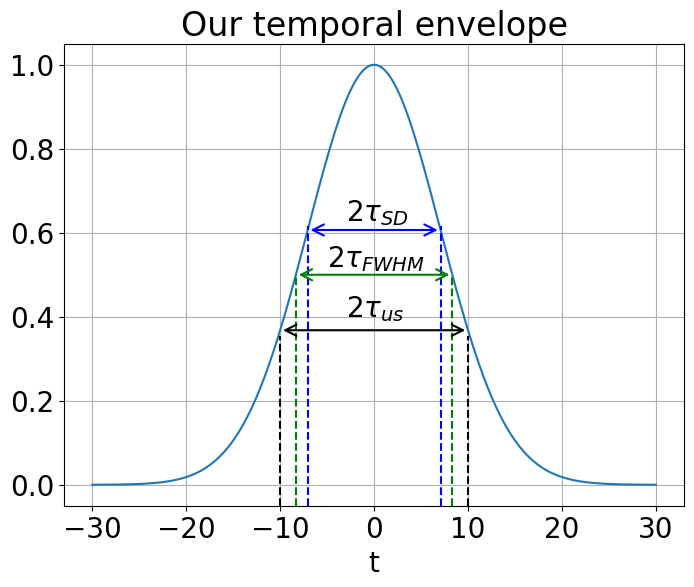

In [74]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.plot(t, envelope)

plt.axvline(tau_us/2, 0, f_us, color='black', linestyle='--')
plt.axvline(-tau_us/2, 0, f_us, color='black', linestyle='--')
ax.annotate(
    "", 
    xy=(-tau_us/2, f_us), xytext=(tau_us/2, f_us),
    arrowprops=dict(arrowstyle="<->", linewidth=1.5)
)
plt.text(-3, 0.4, "$2 \\tau_{us}$")

plt.axvline(tau_FWHM, 0, f_FWHM, color='green', linestyle='--')
plt.axvline(-tau_FWHM, 0, f_FWHM, color='green', linestyle='--')
ax.annotate(
    "", 
    xy=(-tau_FWHM, f_FWHM), xytext=(tau_FWHM, f_FWHM),
    arrowprops=dict(arrowstyle="<->", linewidth=1.5, color='green')
)
plt.text(-5, 0.52, "$2 \\tau_{FWHM}$")

plt.axvline(tau_SD, 0, f_SD, color='blue', linestyle='--')
plt.axvline(-tau_SD, 0, f_SD, color='blue', linestyle='--')
ax.annotate(
    "", 
    xy=(-tau_SD, f_SD), xytext=(tau_SD, f_SD),
    arrowprops=dict(arrowstyle="<->", linewidth=1.5, color='blue')
)
plt.text(-3, 0.63, "$2 \\tau_{SD}$")

plt.grid('on')
plt.xlabel('t')
plt.xticks([-30,-20,-10,0,10,20,30])
plt.title('Our temporal envelope')
plt.savefig('../imgs/formalism/durations.pdf', bbox_inches="tight")
plt.savefig('../imgs/formalism/durations.png', bbox_inches="tight")
plt.show()

## How dipole field looks like

In [15]:
tau = 10e-15
W = 25
lam = 0.8e-6
envelope = "plane"
envelope = "gauss"

mode = "analytic"
field_1 = {
    "field_type": f"dipole_{mode}",
    "envelope": envelope,
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    # "w0": w01,
    "tau": tau,
    "W": W,
}
fields = {'1': field_1}

t0 = 2*tau
x0 = 8*c*tau
box_size = [x0,x0,2*c*tau]

grid_params = {
    "mode": "direct",
    "box_xyz": [x0,x0,x0],
    "Nxyz": get_xyz_size(fields, box_size, grid_res=8),
    "box_t": 2*tau,
    "Nt": 2*get_t_size(-t0/2, t0/2, lam),
}

grid_xyz, grid_t = setup_grids(fields, grid_params)
x, y, z = [ax.ravel() for ax in grid_xyz.xyz]

In [16]:
dipole = DipoleAnalytic(field_1, grid_xyz)
print(dipole.W_num)

25.0


In [17]:
E_out, B_out = dipole.calculate_field(t=0e-15, mode='real')

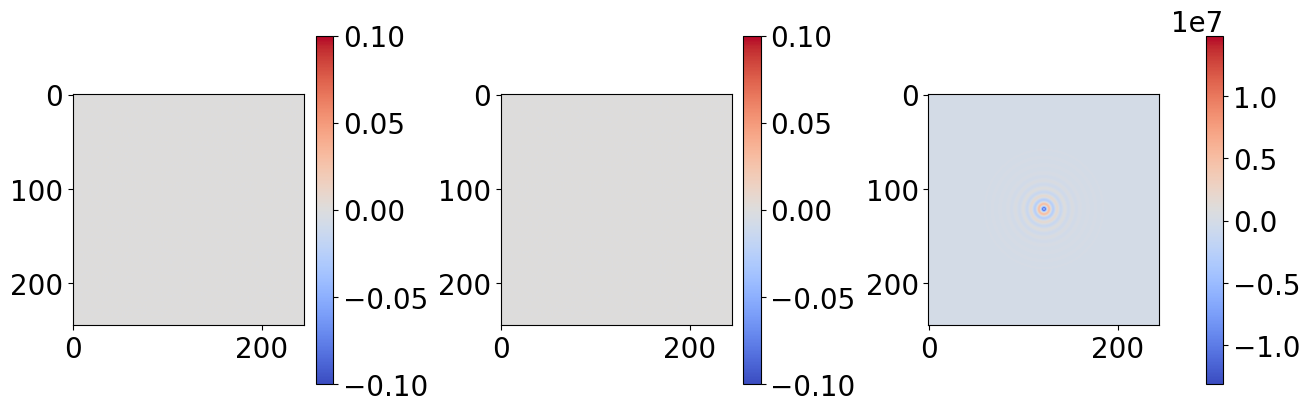

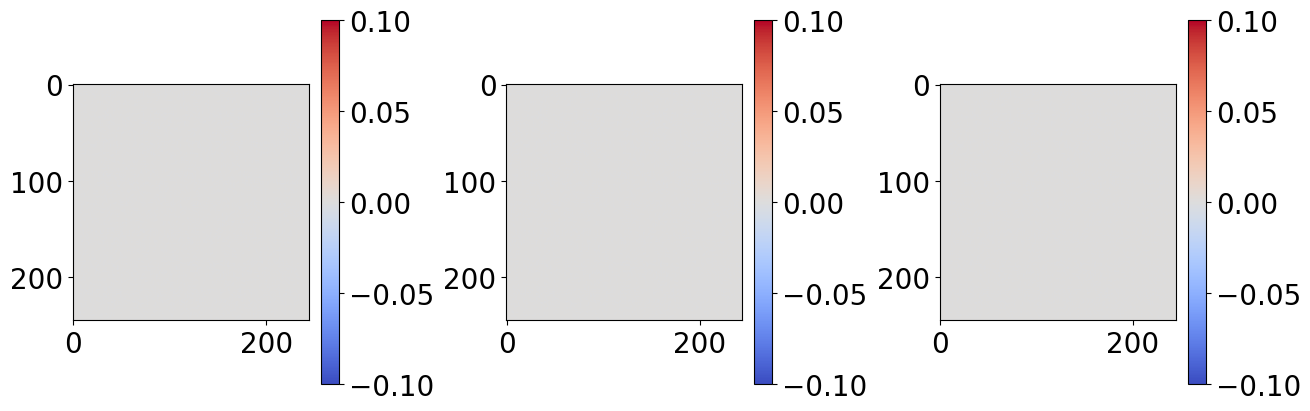

In [18]:
Ex, Ey, Ez = [E for E in E_out]
Bx, By, Bz = [B for B in B_out]

I = ((Ex**2 + Ey**2 + Ez**2) + (Bx**2 + By**2 + Bz**2)) / (8*pi)

nx,ny,nz = Ex.shape

plt.figure(figsize=(13,4), layout='constrained')
for i,E in enumerate((Ex, Ey, Ez)):
    plt.subplot(1,3,i+1)
    plt.imshow(E[:,:,nz//2], cmap='coolwarm')
    plt.colorbar()
plt.show()

plt.figure(figsize=(13,4), layout='constrained')
for i,E in enumerate((Bx, By, Bz)):
    plt.subplot(1,3,i+1)
    plt.imshow(E[:,:,nz//2], cmap='coolwarm')
    plt.colorbar()
plt.show()

2.048316986895447e-21 8803770888743.812


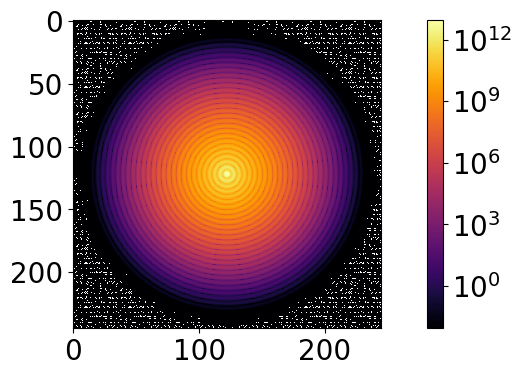

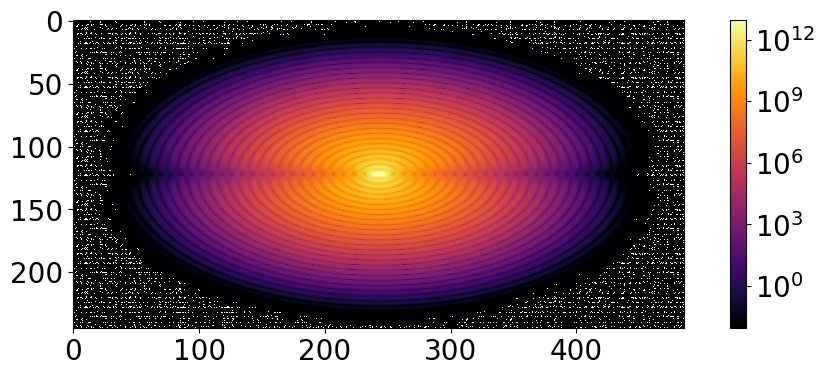

In [19]:
I0 = I[:,:,nz//2]
print(I0.min(), I0.max())
norm = mcolors.LogNorm(vmin=I0.max()*1e-15, vmax=I0.max())

plt.figure(figsize=(12,4))
plt.imshow(I0, norm=norm, cmap='inferno', rasterized=True)
# plt.imshow(I0, cmap='inferno', rasterized=True)
plt.colorbar()
# plt.clim(1e16, I0.max())
plt.show()


I0 = I[:,ny//2,:]
norm = mcolors.LogNorm(vmin=I0.max()*1e-15, vmax=I0.max())
plt.figure(figsize=(12,4))
plt.imshow(I0, norm=norm, cmap='inferno', rasterized=True)
plt.colorbar()
plt.show()

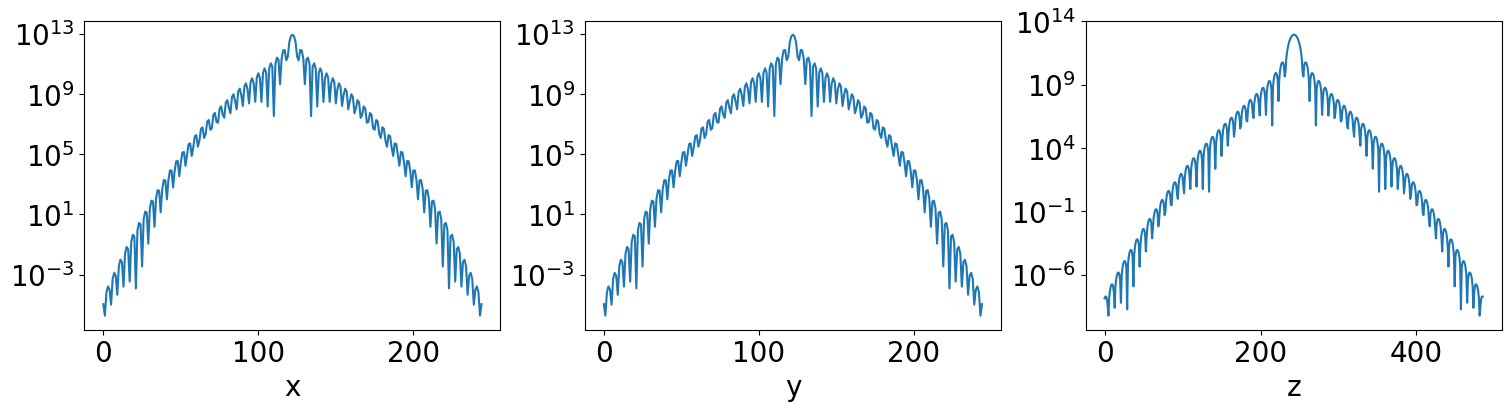

In [20]:
labels = 'x y z'.split()

plt.figure(figsize=(15,4), layout='constrained')
for i,data in enumerate([I[:,ny//2,nz//2], I[nx//2,:,nz//2],
                         I[nx//2,ny//2,:]]):
    plt.subplot(1,3,i+1)
    plt.plot(data)
    plt.xlabel(labels[i])
    plt.yscale('log')
plt.show()

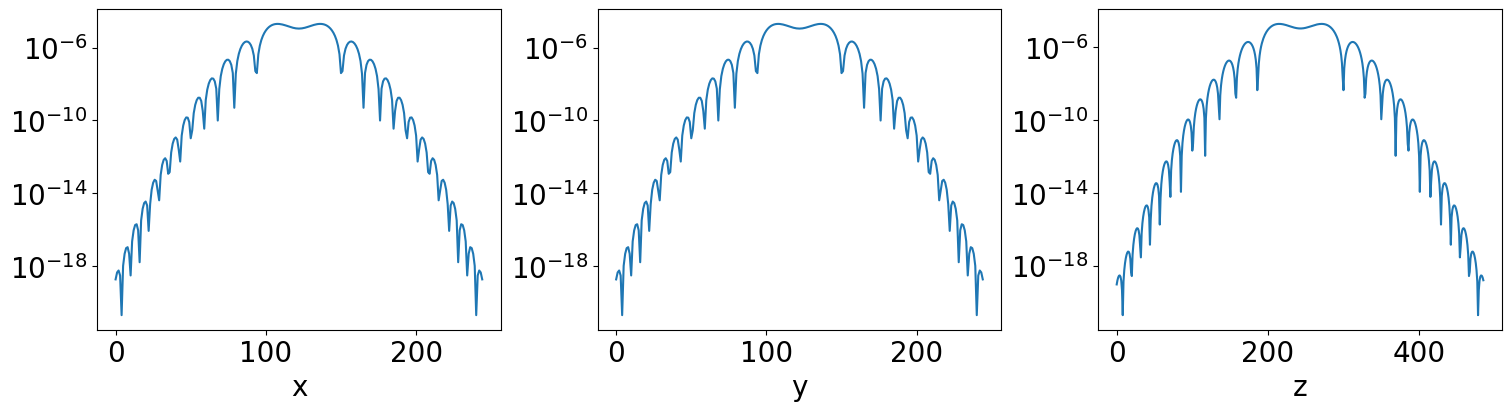

In [21]:
labels = 'x y z'.split()

plt.figure(figsize=(15,4), layout='constrained')
for i,data in enumerate([I[:,0,nz//2], I[0,:,nz//2],
                         I[nx//2,0,:]]):
    plt.subplot(1,3,i+1)
    plt.plot(data)
    plt.xlabel(labels[i])
    plt.yscale('log')
plt.show()

## Dipole vs gaussian

In [3]:
tau_FWHM = 28
taus = convert_tau(tau_FWHM, mode="FWHM")
print(taus)
taus_my = convert_tau(taus["tau"], mode="tau")
print(taus_my)
taus_std = convert_tau(taus["std"], mode="std")
print(taus_std)

{'tau': 33.631427446020595, 'FWHM': 28.0, 'std': 11.890505204032268}
{'tau': 33.631427446020595, 'FWHM': 28.0, 'std': 11.890505204032266}
{'tau': 33.6314274460206, 'FWHM': 28.0, 'std': 11.890505204032268}


In [4]:
tau_FWHM = 28e-15
taus = convert_tau(tau_FWHM, mode="FWHM")
print(taus)

tau = taus["tau"]
W = 30
lam = 0.8e-6
w0 = 1.75e-6/np.sqrt(2)
envelope = "plane"
envelope = "gauss"

mode = "analytic"
field_dipole = {
    "field_type": f"dipole_{mode}",
    "envelope": envelope,
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    # "w0": w01,
    "tau": tau,
    "W": W,
}

field_gauss = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "E0": 1.,
    "W": W,
    "order": 1,
}

fields_d = {'dipole': field_dipole}
fields_g = {'gauss': field_gauss}

grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 20,
    'longitudinal_factor': 8,
    'time_factor': 4,
    'spatial_resolution': 2,
    'time_resolution': 1,
}
grid_xyz, grid_t = setup_grids(fields_g, grid_params)
grid_xyz.get_k_grid()
x, y, z = [ax.ravel() for ax in grid_xyz.xyz]

{'tau': 3.36314274460206e-14, 'FWHM': 2.8e-14, 'std': 1.1890505204032267e-14}


In [5]:
dipole = DipoleAnalytic(field_dipole, grid_xyz)
gauss = GaussianAnalytic(field_gauss, grid_xyz)

/home/maximus/Research/github/quantum-vacuum/src/quvac/field/dipole.py:72: RuntimeWarning: invalid value encountered in divide
  self.nx, self.ny, self.nz = [np.nan_to_num(ax/self.R) for ax in (self.x, self.y, self.z)]


In [6]:
print(f"W (gauss) : {gauss.W_num}")
print(f"W (dipole): {dipole.W_num}")

W (gauss) : 30.0
W (dipole): 30.0


In [7]:
Eg, Bg = gauss.calculate_field(t=0e-15, mode='real')
Ed, Bd = dipole.calculate_field(t=0e-15, mode='real')

In [8]:
Egx, Egy, Egz = [E for E in Eg]
Bgx, Bgy, Bgz = [B for B in Bg]

Edx, Edy, Edz = [E for E in Ed]
Bdx, Bdy, Bdz = [B for B in Bd]

Eg2 = (Egx**2 + Egy**2 + Egz**2)
Bg2 = (Bgx**2 + Bgy**2 + Bgz**2)
Ig = (c**2 * Eg2 + Bg2)/2

Ed2 = (Edx**2 + Edy**2 + Edz**2) * c**2
Bd2 = (Bdx**2 + Bdy**2 + Bdz**2)
Id = (Ed2 + Bd2)/2

Ig_max = Ig.max() / Ec**2
Id_max = Id.max() / Ec**2
print(f"Imax (gauss) : {Ig_max}")
print(f"Imax (dipole): {Id_max}")
print("="*30)

print(f"Emax (gauss) : {np.sqrt(Eg2.max())}")
print(f"Emax (dipole): {np.sqrt(Ed2.max())}")
print("="*30)

print(f"Bmax (gauss) : {np.sqrt(Bg2.max())}")
print(f"Bmax (dipole): {np.sqrt(Bd2.max())}")
print("="*30)

print(f"Imax (gauss) : {Ig.max()}")
print(f"Imax (dipole): {Id.max()}")
print("="*30)

print(f"Id / Ig      : {Id.max()/Ig.max()}")

Imax (gauss) : 1.2598817538267498e-07
Imax (dipole): 4.00167339453032e-06
Emax (gauss) : 2215709.0648470935
Emax (dipole): 3743599358248707.5
Bmax (gauss) : 2215709.0648470935
Bmax (dipole): 0.0
Imax (gauss) : 2.20615935501692e+29
Imax (dipole): 7.007268077540068e+30
Id / Ig      : 31.762293424566902


In [9]:
0.6 * W / (w0**2 * tau_FWHM) / Ec**2

np.float64(2.397514703213154e-10)

## Single simulation with dipole wave

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
# w01 = 1*lam
w02 = 1*lam
theta = 180
beta = 0

mode = 'analytic'
order = 0
parallel = True
parallel = False

channels = False
integrator_type = 'vacuum_emission_channels' if channels else 'vacuum_emission'

# Define fields
field_1 = {
    "field_type": f"dipole_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    # "w0": w01,
    "tau": tau,
    "W": W,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w02,
    "tau": tau,
    "W": W,
    "phase0": 0,
    "order": order,
}

fields_params = {
    'field_1': field_1,
    'field_2': field_2,
}

ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'dynamic',
        'collision_geometry': 'z',
        'transverse_factor': 20,
        'longitudinal_factor': 8,
        'time_factor': 4,
        'spatial_resolution': 1,
        'time_resolution': 2,
    },
    'integrator': {
        'type': integrator_type,
        'probe_pump_idx': {
            'probe': [1],
            'pump': [0],
        }
    },
    'performance': {
        'nthreads': 8,
        'test_run': False
    },
    'cluster_params': {
        'n_jobs': 1,
        'cluster': 'slurm',
        'sbatch_params': {
            'slurm_partition': 'hij-gpu',
            'cpus_per_task': 16,
            'slurm_mem': '100GB',
            'timeout_min': 240,
        },
    },
    'postprocess': {
        'perp_polarization_type': 'optical axis',
        'perp_field_idx': 1,
        'calculate_spherical': False,
        'spherical_params': {
            'angular_resolution': 0.5*np.pi/180.  
        },
        'calculate_discernible': False,
    },
}

if not parallel:
    SCRIPT_PATH = '../src/quvac/simulation.py'
else:
    SCRIPT_PATH = '../src/quvac/simulation_parallel.py'

path = '../data/dipole/test'
if parallel:
    path += '_parallel'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yaml')
write_yaml(ini_file, ini_data)

In [3]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")

Traceback (most recent call last):
  File "/home/maximus/Research/github/quantum-vacuum/notebooks/../src/quvac/simulation.py", line 311, in <module>
    quvac_simulation(args.input, args.output, args.wisdom)
  File "/home/maximus/Research/github/quantum-vacuum/notebooks/../src/quvac/simulation.py", line 276, in quvac_simulation
    timings, memory = run_simulation(ini_config, fields_params, 
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maximus/Research/github/quantum-vacuum/notebooks/../src/quvac/simulation.py", line 139, in run_simulation
    grid_xyz, grid_t = setup_grids(fields_params, grid_params)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maximus/Research/github/quantum-vacuum/src/quvac/grid.py", line 252, in setup_grids
    grid_params = create_dynamic_grid(fields_params, grid_params)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maximus/Research/github/quantum-vacuum/src/quvac/gr